1. Compare data from the two crawls using a series of box plots, where X axis is the crawl
name (Crawl-news, Crawl-gov), and Y axis is one of the metrics given in (a) to (d). For
instance, the box plot for Number of requests will be based on the distribution of number of
requests per website in each crawl. Create a separate box plot for each of the following
metrics, as shown in the example figure below:
a. Page load time (based on load event)
b. Number of requests per website
c. Number of third-party requests per website
d. Number of distinct third-party domains per website

In [7]:
!pip3 install seaborn -q
!pip3 install tld -q
!pip3 install

In [20]:
import os
import json
from urllib.parse import urlparse
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tld import get_fld
import pandas as pd


In [66]:
def create_boxplot(data, title, x_label, y_label, x_ticks=["Government", "News"], filename="boxplot.png"):
    sns.set(style="whitegrid")
    ax = sns.boxplot(data=data)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_xticklabels(x_ticks)
    ax.set_ylabel(y_label)
    plt.savefig(f'boxplots/{filename}')
    plt.show()

In [ ]:
with open('crawl_data_gov_times') as f:
    times_gov_dict = json.load(f)

with open('crawl_data_news_times') as f:
    times_news_dict = json.load(f)

times_gov_list = [dict_val for dict_val in times_gov_dict.values()]
times_news_list = [dict_val for dict_val in times_news_dict.values()]
print(times_gov_list)
print(times_news_list)

sns.set(rc={'figure.figsize': (10, 10)})

create_boxplot([times_gov_list, times_news_list], "Loading Time of Government and News Websites", "Website Type", "Loading Time (s)", filename="gov_news_loading_time.png")



In [24]:
# gov_dir = '..\crawl_data_gov'
# news_dir = '..\crawl_data_news'
gov_dir = '../crawl_data_gov'
news_dir = '../crawl_data_news'
ext = 'har'
num_requests_gov = []
num_requests_news = []
num_third_party_requests_gov = []	
num_third_party_requests_news = []
num_third_party_domains_gov = []
num_third_party_domains_news = []
client_hints_gov = []
client_hints_news = []

def get_third_party_domain_counts(entries, gov_domain):
    distinct_third_party_domains = {}
    num_third_party_requests = 0
    for entry in entries:
        url = entry['request']['url']
        hostname = urlparse(url).hostname
        if hostname and gov_domain not in hostname:
            num_third_party_requests += 1
            tld_1 = get_fld(url)
            if tld_1 not in distinct_third_party_domains:
                distinct_third_party_domains[tld_1] = 0
            else: 
                distinct_third_party_domains[tld_1] += 1
    return num_third_party_requests, distinct_third_party_domains

def get_accept_ch_header_requests(entries):
    accept_ch_hints = {}
    visited_hints_in_website = []
    for entry in entries:
        headers = entry['response']['headers']
        for header in headers:
            if header['name'] == 'accept-ch':
                client_hints = header['value'].split(',')
                for hint in client_hints:
                    hint = hint.strip()
                    if hint in visited_hints_in_website:
                        continue
                    accept_ch_hints[hint] = accept_ch_hints.get(hint, 0) + 1
                    visited_hints_in_website.append(hint)
    return accept_ch_hints

all_third_party_entries_gov = {}
for file in os.listdir(gov_dir):
    if file.endswith(ext):
        with open(gov_dir + '/' + file, 'r', encoding='utf-8') as har_file:
            har_data = json.load(har_file)
            entries = har_data['log']['entries']

            num_requests = len(entries)
            num_requests_gov.append(num_requests)

            num_third_party_requests, distinct_third_party_domains = get_third_party_domain_counts(entries, file.split('.')[0])
            # num_third_party_requests_gov.append(num_third_party_requests)
            # num_third_party_domains_gov.append(len(distinct_third_party_domains))

            # client_hints = get_accept_ch_header_requests(entries)
            # client_hints_gov.append(client_hints)

            # 3 - count most prevalent 3rd party domains
            all_third_party_entries_gov = dict(Counter(all_third_party_entries_gov) + Counter(distinct_third_party_domains))                
    else:
        continue

all_third_party_entries_news = {}
for file in os.listdir(news_dir):
    if file.endswith(ext):
        with open(news_dir + '/' + file, 'r', encoding='utf-8') as har_file:
            har_data = json.load(har_file)
            entries = har_data['log']['entries']

            num_requests = len(entries)
            num_requests_news.append(num_requests)

            num_third_party_requests, distinct_third_party_domains = get_third_party_domain_counts(entries, file.split('.')[0])
            # num_third_party_requests_news.append(num_third_party_requests)
            # num_third_party_domains_news.append(len(distinct_third_party_domains))

            # client_hints = get_accept_ch_header_requests(entries)
            # client_hints_news.append(client_hints)

            # 3 - count most prevalent 3rd party domains
            all_third_party_entries_news = dict(Counter(all_third_party_entries_news) + Counter(distinct_third_party_domains))   

    else:
        continue


# 3 - prevalent third-party domains and if they are trackers

In [ ]:
# 3 - table for most prevalent domains + isTracker
def get_tracking_domains_list():
    with open('disconnect-tracking-services.json', 'r') as f:
        tracking_services = json.load(f)

    all_tracker_domains = set()
    for category in tracking_services['categories'].values():
        for org in category:
            for url in org.values():
                for domains in url.values():
                    all_tracker_domains.update(domains)
    return list(all_tracker_domains)


TRACKING_DOMAINS = get_tracking_domains_list()

def prevalent_tracker_domains_table(third_party_entries):
    data = {
        'Third-party domain': list(third_party_entries.keys()), 
        'Number of distinct websites': list(third_party_entries.values()),    
    }
    table = pd.DataFrame(data)
    table = table.sort_values(by=['Number of distinct websites'], ascending=False, ignore_index=True)
    table['isTracker'] = table['Third-party domain'].apply(lambda x: True if x in TRACKING_DOMAINS else False)
    return table[:10]

In [35]:
prevalent_tracker_domains_table(all_third_party_entries_news)


,Third-party domain,Number of distinct websites,isTracker
0,googlesyndication.com,1228,True
1,doubleclick.net,839,True
2,2mdn.net,575,True
3,taboola.com,473,True
4,pubmatic.com,413,True
5,rubiconproject.com,362,True
6,amazon-adsystem.com,308,True
7,adnxs.com,270,True
8,casalemedia.com,251,True
9,yimg.com,234,True


In [36]:
prevalent_tracker_domains_table(all_third_party_entries_gov)


,Third-party domain,Number of distinct websites,isTracker
0,rijksoverheid.nl,20,False
1,piwik.pro,16,False
2,siteimproveanalytics.io,16,False
3,abtasty.com,15,False
4,gstatic.com,10,True
5,uwv.nl,7,False
6,cookiebot.com,7,False
7,mopinion.com,6,False
8,google-analytics.com,5,True
9,readspeaker.com,4,False


C:\Users\lukev\AppData\Local\Temp\ipykernel_29572\3333070040.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


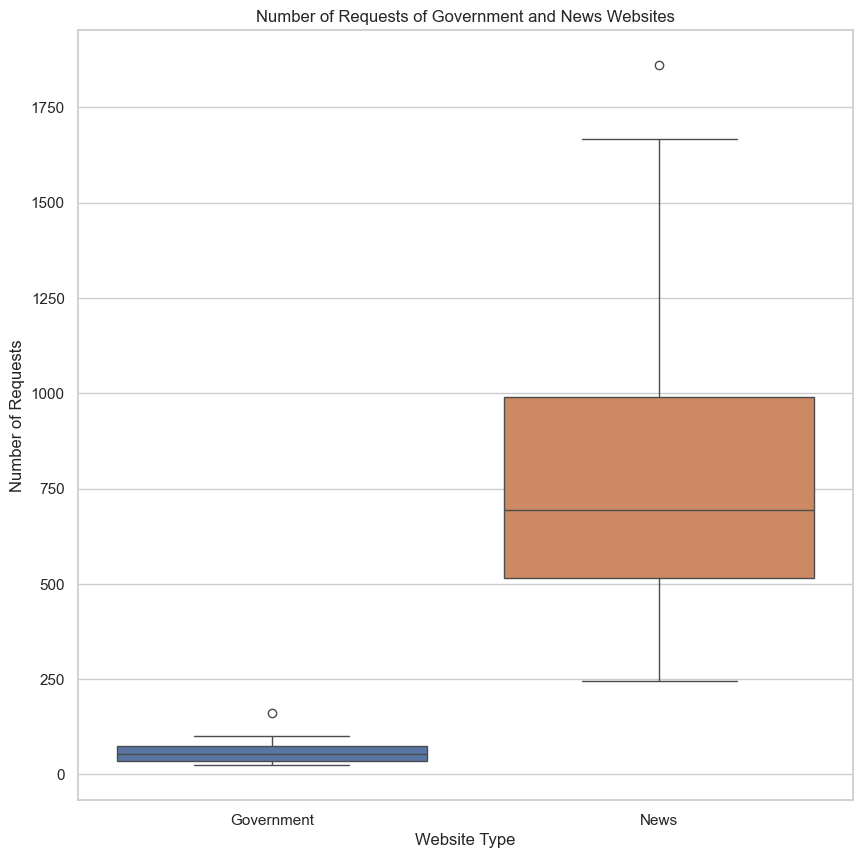

In [69]:
create_boxplot([num_requests_gov, num_requests_news], "Number of Requests of Government and News Websites", "Website Type", "Number of Requests", filename="gov_news_requests.png")

C:\Users\lukev\AppData\Local\Temp\ipykernel_29572\3333070040.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


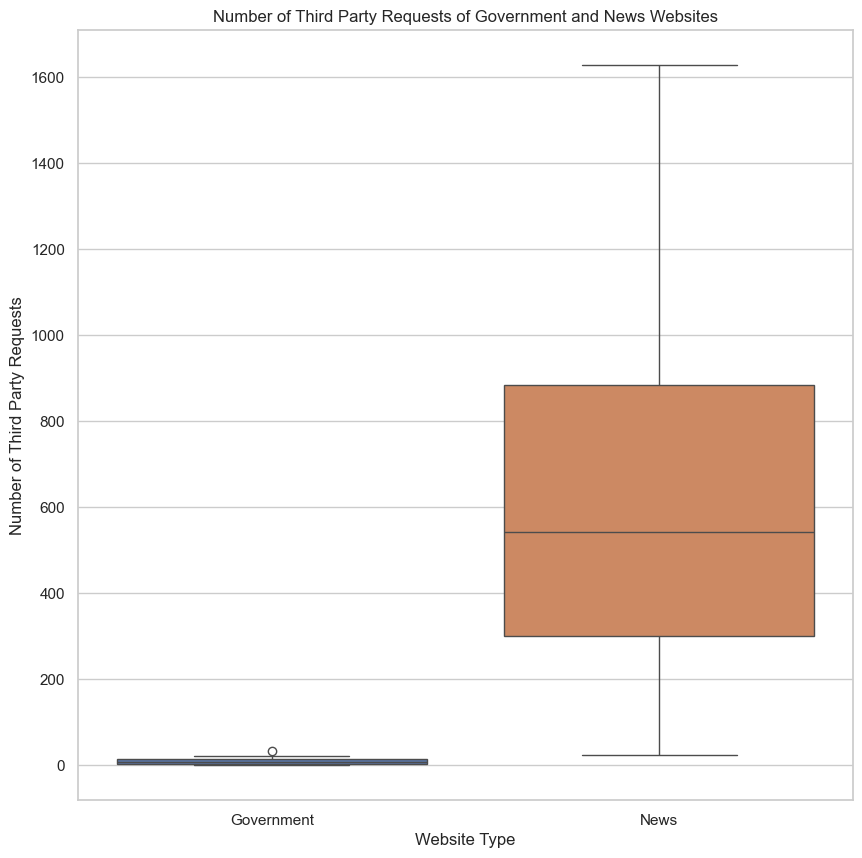

In [70]:
create_boxplot([num_third_party_requests_gov, num_third_party_requests_news], "Number of Third Party Requests of Government and News Websites", "Website Type", "Number of Third Party Requests", filename="gov_news_third_party_requests.png")

C:\Users\lukev\AppData\Local\Temp\ipykernel_29572\3333070040.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


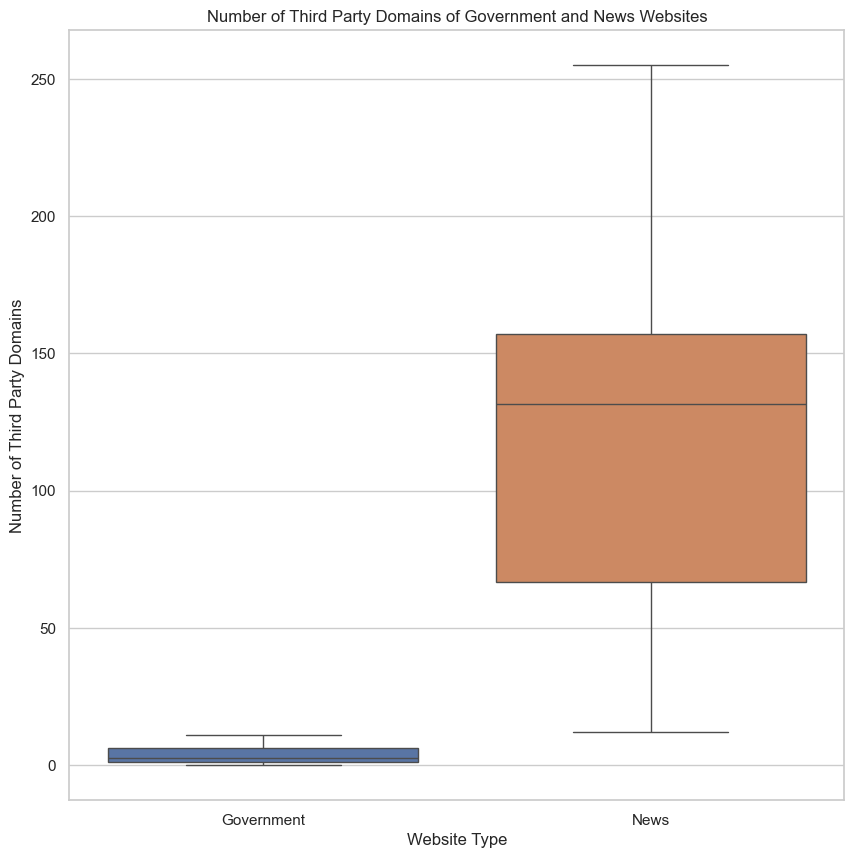

In [71]:
create_boxplot([num_third_party_domains_gov, num_third_party_domains_news], "Number of Third Party Domains of Government and News Websites", "Website Type", "Number of Third Party Domains", filename="gov_news_third_party_domains.png")

In [72]:
print(num_requests_news)
print(num_requests_gov)

print(num_third_party_requests_news)
print(num_third_party_requests_gov)

print(num_third_party_domains_news)
print(num_third_party_domains_gov)


[500, 1062, 522, 665, 1861, 963, 1154, 645, 1668, 379, 720, 668, 246, 371, 284, 751, 967, 738, 596, 1286]
[37, 85, 70, 100, 162, 54, 37, 85, 57, 72, 24, 26, 38, 54, 37, 27, 27, 57, 83, 30]
[266, 860, 284, 472, 1420, 689, 1029, 563, 1627, 134, 521, 457, 24, 306, 187, 610, 956, 605, 399, 957]
[5, 11, 8, 0, 32, 14, 7, 21, 0, 21, 1, 10, 6, 14, 17, 0, 8, 1, 3, 13]
[52, 155, 70, 120, 204, 182, 192, 150, 255, 44, 119, 120, 12, 57, 23, 163, 150, 148, 125, 138]
[2, 4, 4, 0, 9, 8, 1, 11, 0, 6, 1, 2, 3, 8, 1, 0, 1, 1, 3, 7]


In [73]:
# Generate min, median, max values for each metric
metrics = {"loading_time": [times_gov_list, times_news_list], "num_requests": [num_requests_gov, num_requests_news], "num_third_party_requests": [num_third_party_requests_gov, num_third_party_requests_news], "num_third_party_domains": [num_third_party_domains_gov, num_third_party_domains_news]}
for metric, values in metrics.items():
    print(f"Metric: {metric}")
    print('News:')
    print(f"Min: {min(values[1])}")
    print(f"Median: {sum(values[1]) / len(values[1])}")
    print(f"Max: {max(values[1])}")
    print('Government:')
    print(f"Min: {min(values[0])}")
    print(f"Median: {sum(values[0]) / len(values[0])}")
    print(f"Max: {max(values[0])}")

Metric: loading_time
News:
Min: 0.4088881015777588
Median: 1.244267737865448
Max: 3.8423259258270264
Government:
Min: 0.2826869487762451
Median: 0.887889814376831
Max: 4.913503885269165
Metric: num_requests
News:
Min: 246
Median: 802.3
Max: 1861
Government:
Min: 24
Median: 58.1
Max: 162
Metric: num_third_party_requests
News:
Min: 24
Median: 618.3
Max: 1627
Government:
Min: 0
Median: 9.6
Max: 32
Metric: num_third_party_domains
News:
Min: 12
Median: 123.95
Max: 255
Government:
Min: 0
Median: 3.6
Max: 11


| Metric                       | Min (News) | Median (News) | Max (News) | Min (Gov) | Median (Gov) | Max (Gov) |
|------------------------------|------------|---------------|------------|-----------|--------------|-----------|
| **Loading time (s)**         | 0.41       | 1.24          | 3.84       | 0.28      | 0.89         | 4.91      |
| **Number of requests**       | 246        | 802.3         | 1861       | 24        | 58.1         | 162       |
| **Number of third-party requests** | 24         | 618.3         | 1627       | 0         | 9.6          | 32        |
| **Number of third-party domains**  | 12         | 123.95        | 255        | 0         | 3.6          | 11        |


$$
\begin{array}{l|ccc|ccc}
\hline
\textbf{Metric} & \textbf{Min (News)} & \textbf{Median (News)} & \textbf{Max (News)} & \textbf{Min (Gov)} & \textbf{Median (Gov)} & \textbf{Max (Gov)} \\
\hline
\text{Loading time (s)} & 0.41 & 1.24 & 3.84 & 0.28 & 0.89 & 4.91 \\
\text{Number of requests} & 246 & 802.3 & 1861 & 24 & 58.1 & 162 \\
\text{Number of third-party requests} & 24 & 618.3 & 1627 & 0 & 9.6 & 32 \\
\text{Number of third-party domains} & 12 & 123.95 & 255 & 0 & 3.6 & 11 \\
\hline
\end{array}
$$


$$
\begin{array}{l|ccc|ccc}
\hline
\textbf{Metric} & \multicolumn{3}{c|}{\textbf{News}} & \multicolumn{3}{c}{\textbf{Government}} \\
& \textbf{Min} & \textbf{Median} & \textbf{Max} & \textbf{Min} & \textbf{Median} & \textbf{Max} \\
\hline
\text{Loading time (s)} & 0.41 & 1.24 & 3.84 & 0.28 & 0.89 & 4.91 \\
\text{Number of requests} & 246 & 802.3 & 1861 & 24 & 58.1 & 162 \\
\text{Number of third-party requests} & 24 & 618.3 & 1627 & 0 & 9.6 & 32 \\
\text{Number of third-party domains} & 12 & 123.95 & 255 & 0 & 3.6 & 11 \\
\hline
\end{array}
$$



In [122]:
sorted_client_hints_news = {k: v for k, v in sorted(client_hints_news[0].items(), key=lambda item: item[1], reverse=True)}
sorted_client_hints_gov = {k: v for k, v in sorted(client_hints_gov[0].items(), key=lambda item: item[1], reverse=True)}

# Combine client hints from all websites
all_client_hints_gov = {}
for hints in client_hints_gov:
    for hint, count in hints.items():
        all_client_hints_gov[hint] = all_client_hints_gov.get(hint, 0) + count

# Sort client hints by count
sorted_all_client_hints_gov = {k: v for k, v in sorted(all_client_hints_gov.items(), key=lambda item: item[1], reverse=True)}

all_client_hints_news = {}
for hints in client_hints_news:
    for hint, count in hints.items():
        all_client_hints_news[hint] = all_client_hints_news.get(hint, 0) + count

sorted_all_client_hints_news = {k: v for k, v in sorted(all_client_hints_news.items(), key=lambda item: item[1], reverse=True)}

# Gov and news websites client hints combined
all_client_hints = {}
for hint, count in sorted_all_client_hints_gov.items():
    all_client_hints[hint] = all_client_hints.get(hint, 0) + count

for hint, count in sorted_all_client_hints_news.items():
    all_client_hints[hint] = all_client_hints.get(hint, 0) + count

sorted_all_client_hints = {k: v for k, v in sorted(all_client_hints.items(), key=lambda item: item[1], reverse=True)}

# Get 3 most common client hints
top_3_client_hints = list(sorted_all_client_hints.keys())[:3]
print(top_3_client_hints)

# Get counts for top 3 client hints
top_3_client_hints_counts = []
counts_gov = {}
counts_news = {}
for hint in top_3_client_hints: 
    counts_gov[hint] = sorted_all_client_hints_gov.get(hint, 0)
    counts_news[hint] = sorted_all_client_hints_news.get(hint, 0)
print(counts_gov)
print(counts_news)


['Sec-CH-UA-Arch', 'Sec-CH-UA-Bitness', 'Sec-CH-UA-Full-Version-List']
{'Sec-CH-UA-Arch': 1, 'Sec-CH-UA-Bitness': 1, 'Sec-CH-UA-Full-Version-List': 1}
{'Sec-CH-UA-Arch': 19, 'Sec-CH-UA-Bitness': 19, 'Sec-CH-UA-Full-Version-List': 19}


| Client Hint                | Number of websites (Crawl-gov) | Number of websites (Crawl-news) |
|----------------------------|---------------------------------|--------------------------------|
| Sec-CH-UA-Full-Version-List | 1                               | 19                             |
| Sec-CH-UA-Bitness          | 1                               | 19                             |
| Sec-CH-UA-Arch             | 1                               | 19                             |


$$
\begin{array}{l|c|c}
\hline
\text{Client Hint} & \text{Number of websites (Crawl-gov)} & \text{Number of websites (Crawl-news)} \\
\hline
\text{Sec-CH-UA-Full-Version-List} & 1 & 19 \\
\text{Sec-CH-UA-Bitness} & 1 & 19 \\
\text{Sec-CH-UA-Arch} & 1 & 19 \\
\hline
\end{array}
$$


\begin{table}[h]
    \centering
    \begin{tabular}{l|c|c}
        \hline
        Client Hint & Number of websites (Crawl-gov) & Number of websites (Crawl-news) \\
        \hline
        Sec-CH-UA-Full-Version-List & 1 & 19 \\
        Sec-CH-UA-Bitness & 1 & 19 \\
        Sec-CH-UA-Arch & 1 & 19 \\
        \hline
    \end{tabular}
    \caption{Client Hints comparison between Crawl-news and Crawl-gov (Reversed Order)}
    \label{tab:client_hints_updated}
\end{table}
